In [87]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import color
import cv2
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import LabelEncoder
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from skimage.transform import resize
from numpy.random import seed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from keras.layers import Dropout


***Data Preprocessing***

In [88]:
# Function to load and preprocess images
def load_and_preprocess_image(file_path, target_size=(128, 128)):
    # Load image
    image = Image.open(file_path).convert('RGB')  # Ensures image is RGB
    # Resize image, this is done to standardize the input size for convolutional neural networks (CNNs) used in image processing tasks.
    image = image.resize(target_size)
    # Convert image to NumPy array and normalize pixel values
    image_array = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image_array

In [89]:
# Folders containing JPEG image files
folders = {
    "donald": "donald",
    "mickey": "mickey",
    "minion": "minion",
    "pooh": "pooh",
    "pumba": "pumba",
    "powerpuff": "powerpuff",
    "olaf" : "olaf"
}

# Parent folder for the test dataset
parent_folder = "test"

# Dictionary to hold image files from each folder
image_files = {
    folder: [file for file in os.listdir(folder) if file.endswith((".jpg", ".jpeg", ".png"))]
    for folder in folders.values()
}

test_image_files = {
    folder: [file for file in os.listdir(os.path.join(parent_folder, folder)) if file.endswith((".jpg", ".jpeg", ".png"))]
    for folder in folders.values()
}

# Create an empty list to store image data
dataset = []
dataset_showcase = []
labels = []
labels_showcase = []

# Iterate over each folder and its image files
for folder, files in image_files.items():
    for file_name in files:
        file_path = os.path.join(folder, file_name)
        try:
            image_array = load_and_preprocess_image(file_path)
            dataset.append(image_array)
            labels.append(folder) 
        except Exception as e:
            print(f"Failed to process {file_path}: {str(e)}")

# Iterate over test folder
for folder, files in test_image_files.items():
    for file_name in files:
        file_path = os.path.join(parent_folder, folder, file_name)
        try:
            image_array = load_and_preprocess_image(file_path)
            dataset_showcase.append(image_array)
            labels_showcase.append(folder) 
        except Exception as e:
            print(f"Failed to process {file_path}: {str(e)}")

# Convert the list of image arrays to a NumPy array
dataset = np.array(dataset)
labels = np.array(labels)
dataset_showcase = np.array(dataset_showcase)
labels_showcase = np.array(labels_showcase)

c:\Users\uafa6\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [90]:
unique, counts = np.unique(labels, return_counts=True)
category_counts = dict(zip(unique, counts))
print(category_counts)

{'donald': 68, 'mickey': 79, 'minion': 70, 'olaf': 79, 'pooh': 63, 'powerpuff': 55, 'pumba': 52}


In [91]:
def segment_image_using_kmeans(image_array):
    # Reshape the image to a 2D array of pixels
    pixels = image_array.reshape(-1, 3)

    # Apply K-means clustering with specified initial centroids
    kmeans = KMeans(n_clusters=2, n_init=1, random_state=42)
    labels = kmeans.fit_predict(pixels)

    # Reshape the labels back into the original image shape
    segmented_image = labels.reshape(image_array.shape[0], image_array.shape[1])

    return segmented_image



In [92]:
def visualize_image(segmented_image, title):
    plt.imshow(segmented_image, cmap='viridis')  # 'viridis' is a good colormap to differentiate clusters
    plt.title(title)
    plt.axis('off')
    plt.show()

In [93]:
''' 
The function convert_to_grayscale takes a segmented image as input and normalizes its values to the range 0-255, 
# effectively converting it to a grayscale image. By converting the segmented image to grayscale, you can visualize 
the segmentation results more clearly, making it easier to identify distinct regions and boundaries.
'''

def convert_to_grayscale(segmented_image):
    # Normalize the segmented image to the range 0-255 for grayscale display
    max_label = segmented_image.max()
    min_label = segmented_image.min()
    grayscale_image = ((segmented_image - min_label) / (max_label - min_label)) * 255
    # By converting the grayscale image to uint8, you reduce the memory required to store each pixel value from 64 bits to 8 bits.
    grayscale_image = grayscale_image.astype(np.uint8)
    return grayscale_image

In [94]:
'''
Pixels with intensities greater than or equal to the threshold value are set to 1, 
while pixels with intensities below the threshold are set to 0
'''
def convert_to_binary(segmented_image, threshold):
    # Convert segmented_image to a numerical dtype
    segmented_image = segmented_image.astype(np.uint8)
    
    if(segmented_image[0,0] > 127):
        binary_mask = np.where(segmented_image <= threshold, 255, 0).astype(np.uint8)
    else:
        binary_mask = np.where(segmented_image >= threshold, 255, 0).astype(np.uint8)

    # Apply thresholding to convert the segmented image to a binary mask
    return binary_mask

In [95]:
def apply_morphological_operations(binary_mask):
    # Apply morphological operations to refine the binary mask
    kernel = np.ones((5, 5), np.uint8)
    # Perform dilation to connect nearby pixels of the same value
    dilated_mask = cv2.dilate(binary_mask, kernel, iterations=2)
    # Removes pixels from the boundaries of objects, effectively shrinking them.
    eroded_mask = cv2.erode(dilated_mask, kernel)
    return eroded_mask

In [96]:
def extract_character(image_array, binary_mask):
    # Convert the binary mask to a boolean mask where True represents the character region
    character_mask = binary_mask.astype(bool)
    
    # Create an empty array with the same shape as the original image
    character_image = np.zeros_like(image_array)
    
    # Apply the mask to each color channel
    for i in range(3):  # Assuming the image is RGB
        character_image[:,:,i] = image_array[:,:,i] * character_mask
    
    return character_image

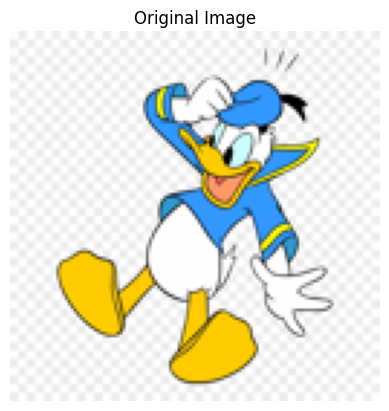

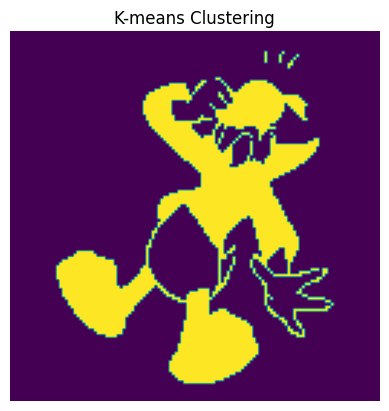

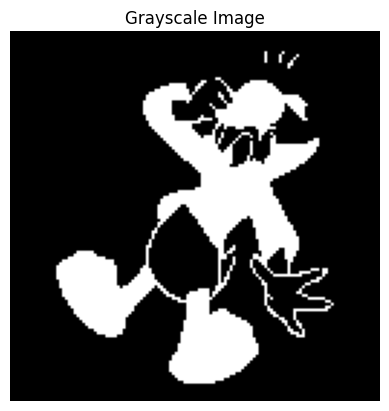

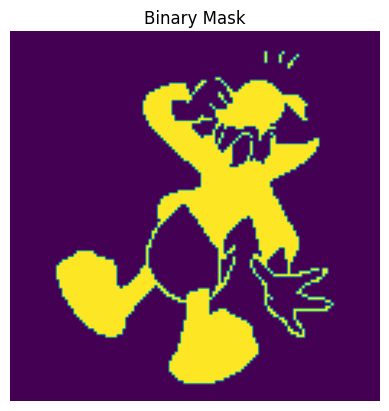

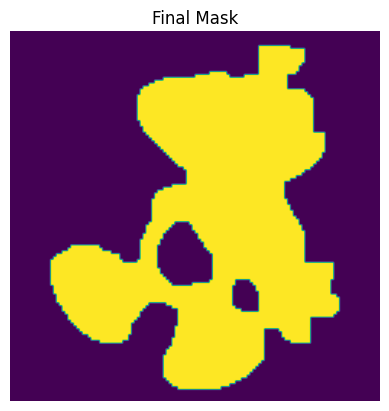

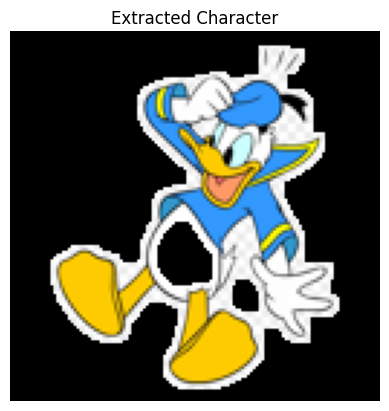

In [97]:
image = dataset[1]

visualize_image(image, 'Original Image')

segmented_image = segment_image_using_kmeans(image)
visualize_image(segmented_image, 'K-means Clustering')

gray_image = convert_to_grayscale(segmented_image)
plt.imshow(gray_image, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')
plt.show()

binary_mask = convert_to_binary(gray_image, 150)
visualize_image(binary_mask, 'Binary Mask')

final_mask = apply_morphological_operations(binary_mask)
visualize_image(final_mask, 'Final Mask')


character_image = extract_character(image, final_mask)

plt.imshow(character_image)
plt.title('Extracted Character')
plt.axis('off')
plt.show()


In [98]:
def extract_all_characters_from_image(dataset):

    characters = []
    for image in dataset:
        segmented_image = segment_image_using_kmeans(image)
        gray_image = convert_to_grayscale(segmented_image)
        binary_mask = convert_to_binary(gray_image, 150)
        final_mask = apply_morphological_operations(binary_mask)
        character_image = extract_character(image, final_mask)
        characters.append(character_image)
    return characters

In [99]:
def extract_character_from_image(image):
    segmented_image = segment_image_using_kmeans(image)
    gray_image = convert_to_grayscale(segmented_image)
    binary_mask = convert_to_binary(gray_image, 150)
    final_mask = apply_morphological_operations(binary_mask)
    character_image = extract_character(image, final_mask)
    return character_image

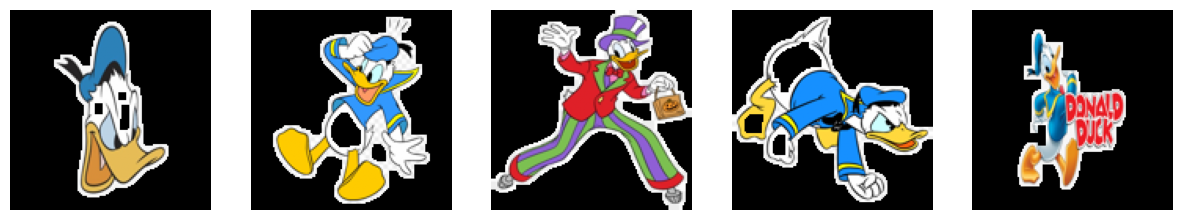

In [100]:
extracted_characters = extract_all_characters_from_image(dataset)

# Display the first 5 extracted characters
plt.figure(figsize=(15, 5))
for i, character in enumerate(extracted_characters[:5]):

    resized_character = resize(character, (128,128))
    plt.subplot(1, 5, i + 1)
    plt.imshow(resized_character, cmap='gray')
    plt.axis('off')
plt.show()

In [101]:
def extract_hog_features(image, pixels_per_cell=(16, 16), cells_per_block=(1, 1), orientations=9):
    # Convert to grayscale if RGB, check if image is already grayscale
    if image.ndim == 3:
        image = color.rgb2gray(image)
    # Extract HOG features, specifying that the input image is grayscale so no channel_axis is needed
    features = hog(image, orientations=orientations, pixels_per_cell=pixels_per_cell,
                           cells_per_block=cells_per_block, visualize=False, feature_vector=True)
    return features

def extract_color_histogram(image, bins=256):
    # Convert image to uint8 if it's not already
    if image.dtype != np.uint8:
        image = np.uint8(image * 255)
    hist = []
    for i in range(3):  # Compute histogram for each color channel
        hist_channel = cv2.calcHist([image], [i], None, [bins], [0, 256])
        cv2.normalize(hist_channel, hist_channel)
        hist.append(hist_channel)
    return np.concatenate(hist).flatten()

def extract_combined_features(image):
    hog_features = extract_hog_features(image)
    color_features = extract_color_histogram(image)
    return np.concatenate((hog_features, color_features))

In [102]:
# Create an empty list to store feature vectors
character_features = []

# Loop through each image in the dataset
for image in extracted_characters:
    features = extract_combined_features(image)
    character_features.append(features)

# Convert the list of feature vectors to a NumPy array
character_features_array = np.array(character_features)

In [103]:
# Flatten all images
flattened_character_images = []
for character in character_features_array:
    flattened_image = character.flatten()
    flattened_character_images.append(flattened_image)

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(flattened_character_images, labels, test_size=0.2, random_state=42,stratify=labels)

### MODELS

In [104]:
# Initialize the KNN model with current hyperparameters
knn = KNeighborsClassifier(n_neighbors=15, metric='manhattan')

# Train the model
knn.fit(X_train, y_train)

# Perform cross-validation
scores = cross_val_score(knn, X_train, y_train, cv=5)  # cv=5 specifies 5-fold cross-validation

# Calculate the average accuracy
average_accuracy = scores.mean()

# Print the average accuracy
print(f"Average Accuracy: {average_accuracy*100:.2f}%")

Average Accuracy: 39.26%


In [105]:
# Support Vector Machine (SVM) Classifier

# Create and train the SVM classifier
model = SVC(gamma=2, C=1, random_state=42)
model.fit(X_train, y_train)

# Perform cross-validation
scores = cross_val_score(model, X_train, y_train, cv=5)  # cv=5 specifies 5-fold cross-validation

# Calculate the average accuracy
average_accuracy = scores.mean()

# Print the average accuracy
print(f"Average Accuracy: {average_accuracy*100:.2f}%")

Average Accuracy: 18.28%


In [106]:
# Random Tree Forest Classifier

forest = RandomForestClassifier(n_estimators = 300, max_depth = 100, 
                                max_features = 40, random_state = 42)
forest.fit(X_train, y_train)

# Perform cross-validation
scores = cross_val_score(forest, X_train, y_train, cv=5)  # cv=5 specifies 5-fold cross-validation

# Calculate the average accuracy
average_accuracy = scores.mean()

# Print the average accuracy
print(f"Average Accuracy: {average_accuracy*100:.2f}%")


Average Accuracy: 68.80%


### Use the pictures in the test folder to visualise the model's performance

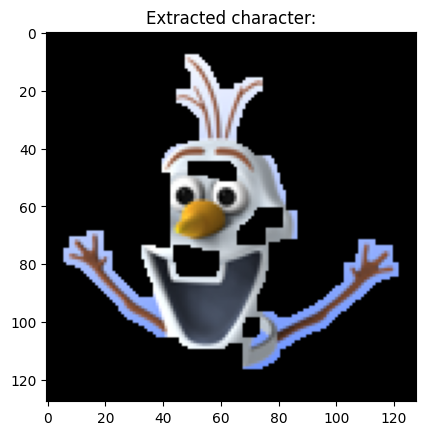

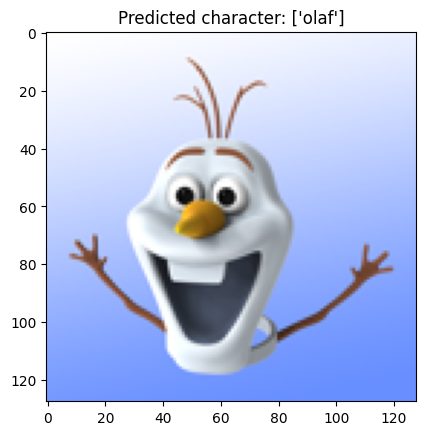

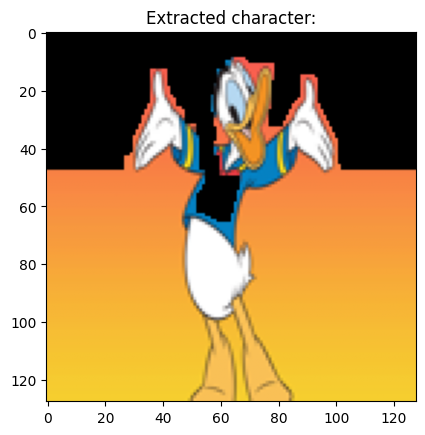

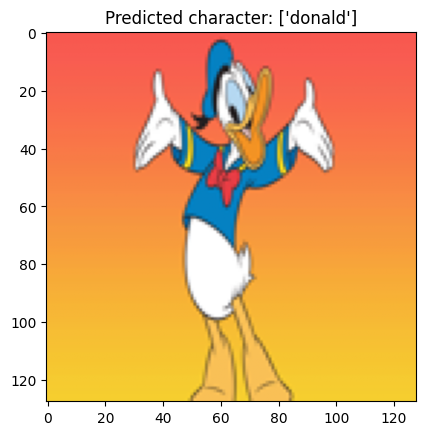

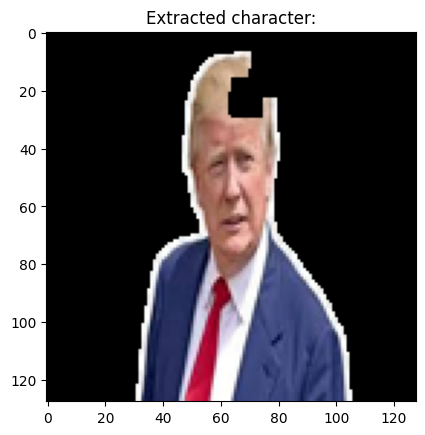

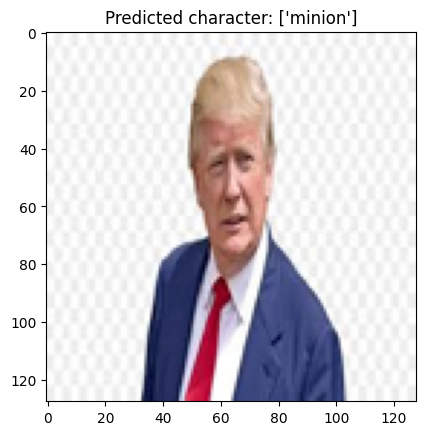

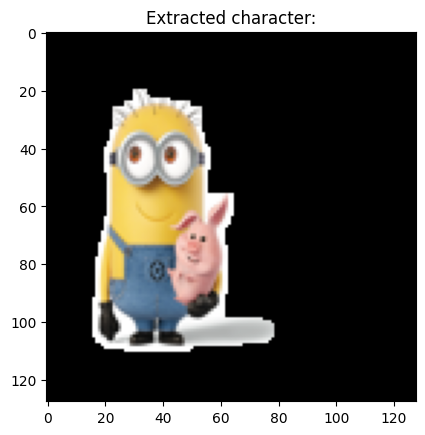

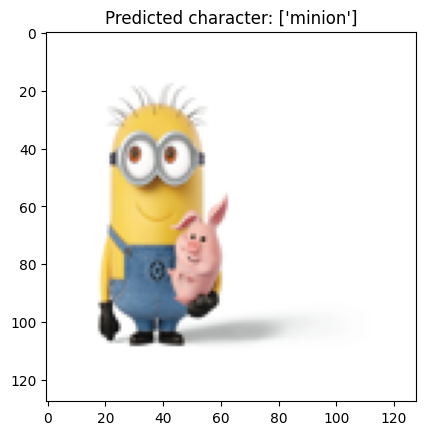

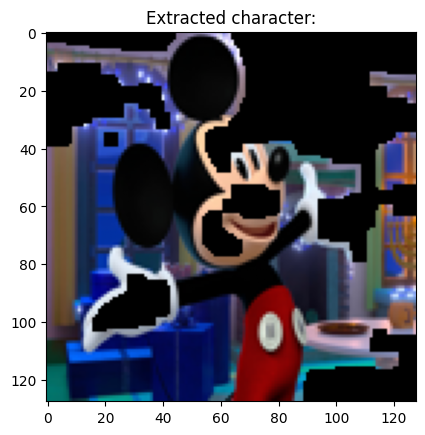

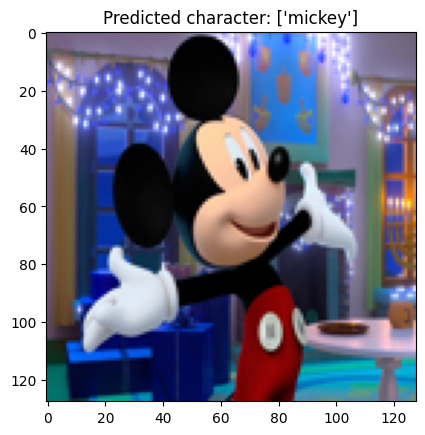

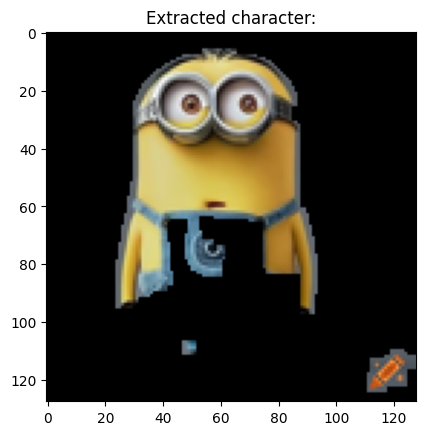

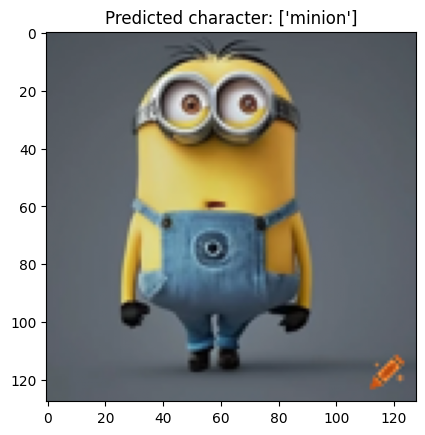

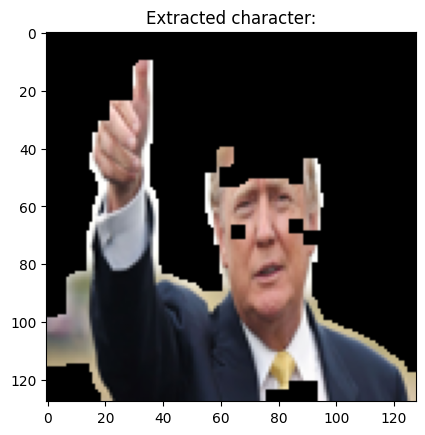

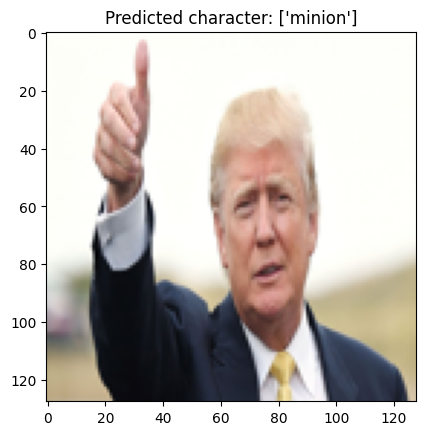

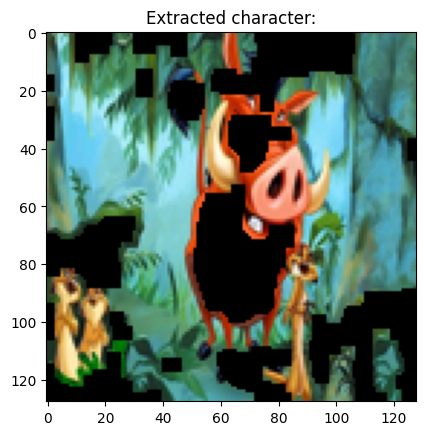

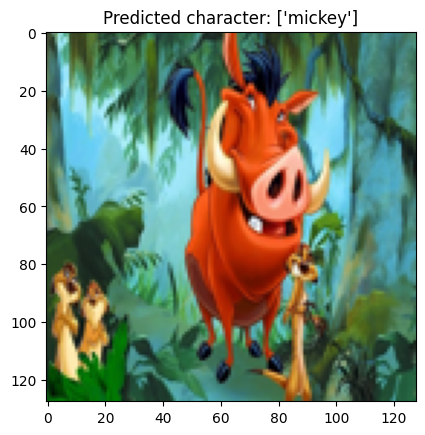

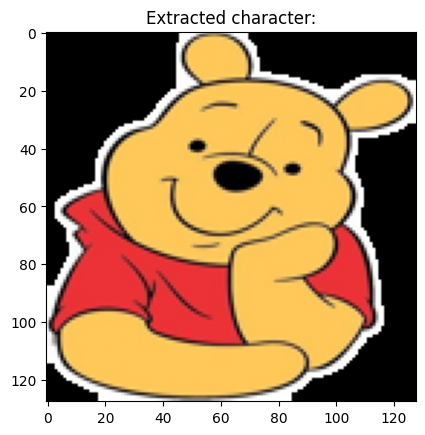

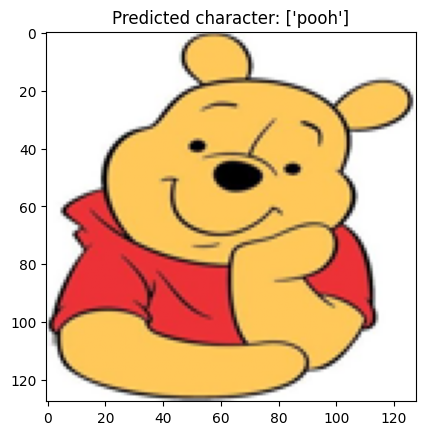

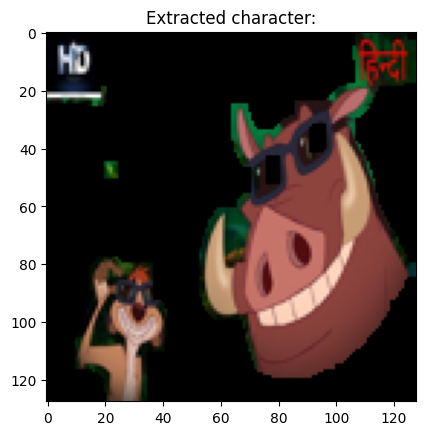

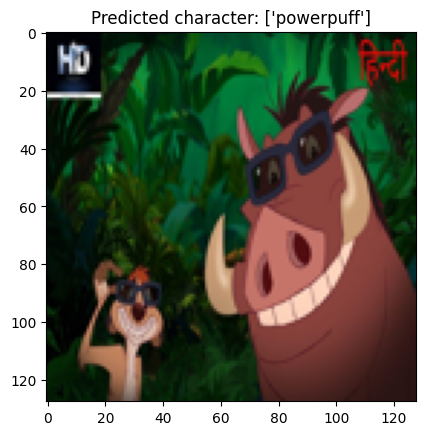

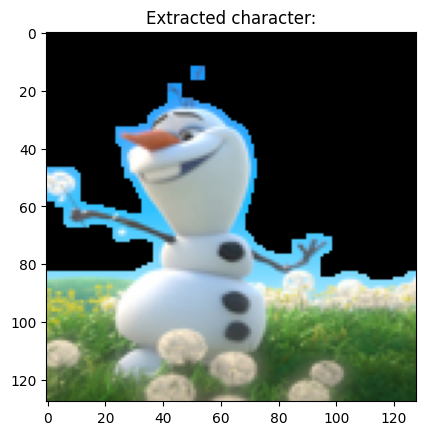

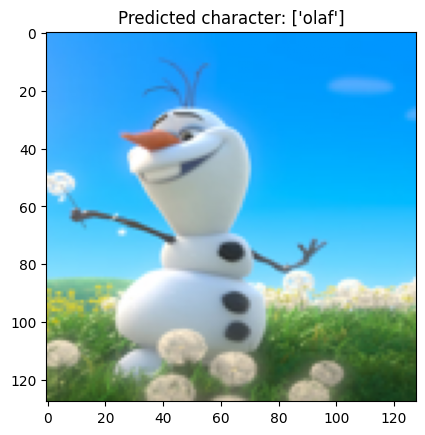

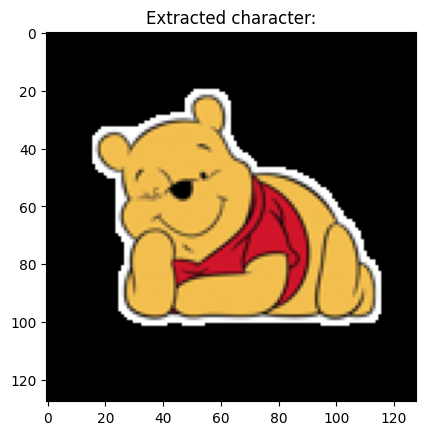

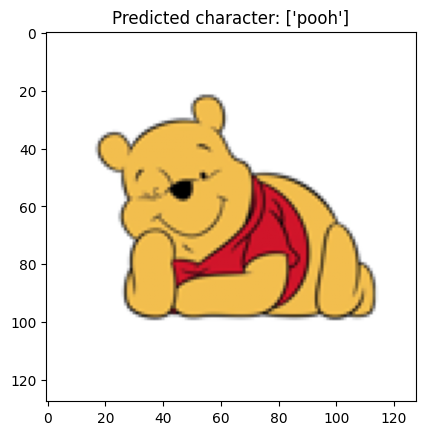

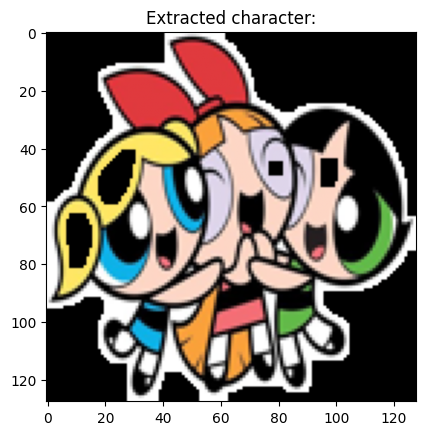

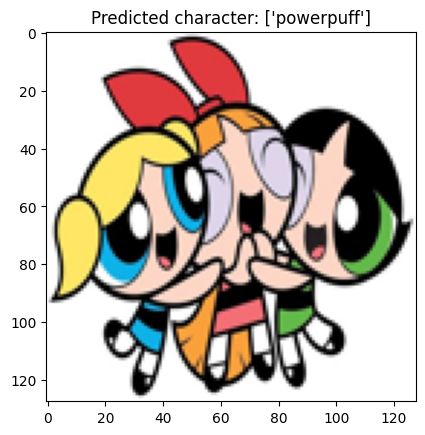

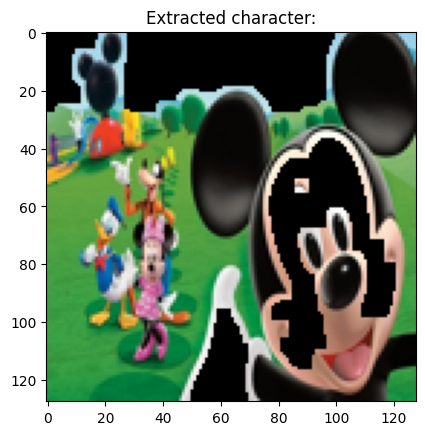

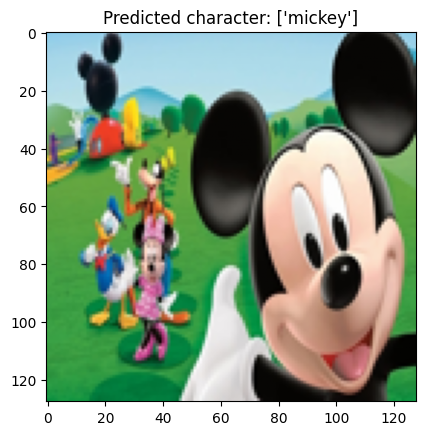

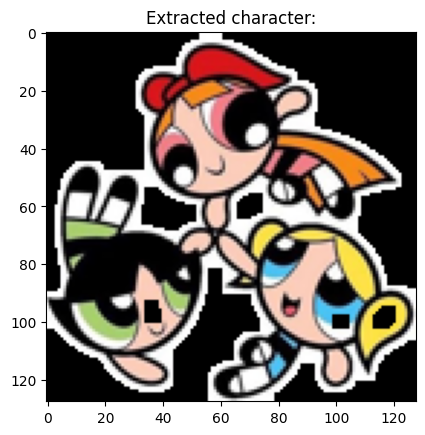

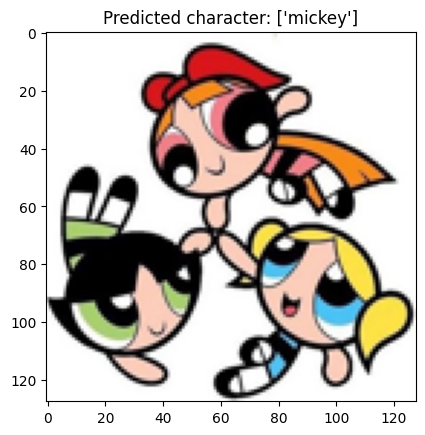

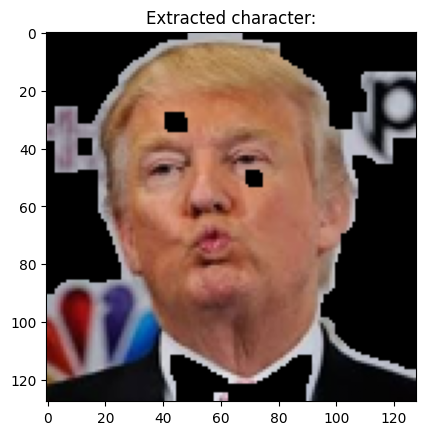

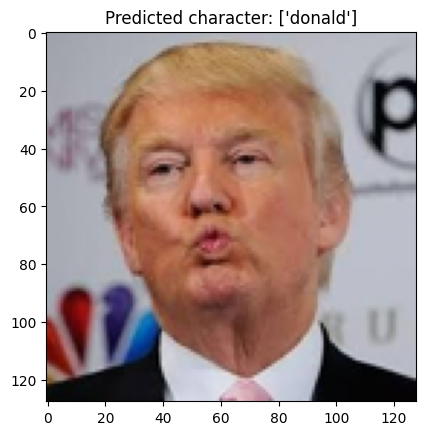

In [107]:
# Select 3 random images from the test set
random_indices = random.sample(range(dataset_showcase.shape[0]), 16)

for i in random_indices:
    # Process the image
    image = dataset_showcase[i]
    extracted_character = extract_character_from_image(image)

   
    plt.imshow(extracted_character, cmap='gray')
    plt.title(f'Extracted character:')
    plt.show()

    selected_character_features = extract_combined_features(extracted_character)
    
    # Flatten the image
    flattened_image = selected_character_features.flatten().reshape(1, -1)
    
    # Predict the label
    predicted_label = forest.predict(flattened_image)
    
    # Visualize the image and the label
    plt.imshow(image, cmap='gray')
    plt.title(f'Predicted character: {predicted_label}')
    plt.show()

## Train CNN to see if we can get better accuracy

In [108]:
X_cnn = dataset
y_cnn = labels

# Fit the encoder and transform y_cnn to integers
le = LabelEncoder()
y_cnn_encoded = le.fit_transform(y_cnn)

Y_cnn = to_categorical(y_cnn_encoded, num_classes=7)

resized_images = []

for image in X_cnn:
    resized_image = cv2.resize(image, (254, 254))
    resized_images.append(resized_image)

X_cnn = np.array(resized_images)

X_train_cnn, X_test_cnn, Y_train_cnn, Y_test_cnn = train_test_split(X_cnn, Y_cnn, stratify = Y_cnn)

print(X_train_cnn.shape)

(349, 254, 254, 3)


In [109]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation = 'relu', input_shape = (254,254,3)))
model.add(MaxPooling2D(pool_size = (2,2)))

# 2 convulutional layers to detect more complex shapes
model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dense(units = 7, activation = 'softmax'))


adam = optimizers.Adam(learning_rate = 0.001)
model.compile(loss='categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

history = model.fit(X_train_cnn, Y_train_cnn, epochs = 10, batch_size = 20, validation_split = 0.3, verbose = 1)

c:\Users\uafa6\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 524ms/step - accuracy: 0.1410 - loss: 10.3205 - val_accuracy: 0.1429 - val_loss: 1.8677
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 509ms/step - accuracy: 0.3063 - loss: 1.7299 - val_accuracy: 0.4952 - val_loss: 1.4605
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 512ms/step - accuracy: 0.8016 - loss: 0.8888 - val_accuracy: 0.7429 - val_loss: 0.7531
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 537ms/step - accuracy: 0.9691 - loss: 0.2144 - val_accuracy: 0.6762 - val_loss: 0.9676
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 497ms/step - accuracy: 0.9683 - loss: 0.1061 - val_accuracy: 0.7143 - val_loss: 0.7454
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 519ms/step - accuracy: 0.9967 - loss: 0.0273 - val_accuracy: 0.7810 - val_loss: 0.6848
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 503ms/step - accuracy: 0.9919 - loss: 0.0375 - val_accuracy: 0.6190 - val_loss: 1.1315
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 498ms/step - accuracy: 0.9841 - loss: 0.0460 - val_accuracy: 0

In [110]:
print("Accuracy on test data: {}".format(model.evaluate(X_test_cnn, Y_test_cnn)))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.7425 - loss: 1.0419
Accuracy on test data: [0.9434215426445007, 0.752136766910553]
